# Node2vec

Node2vec [[1]](#fn1) is a method based on the idea first implemented in the DeepWalk [[2]](#fn2) algorithm that nodes of a graph can be treated as words and random walks as sentences. Consequently, the method embedds the nodes of a network into a _k_-dimensional space. Using this representation, tasks such as classification and multi-label classification of nodes and link prediction become easy because of the convenient representation of nodes as rows in the $NxK$ embedding matrix. We demonstrate node2vec on a network which describes dependencies between python packages.


---
<span id="fn1"> [1] Aditya Grover and Jure Leskovec. node2vec: Scalable feature learning for networks. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pages 855–864, 2016. </span>

<span id="fn2"> [2] Bryan Perozzi, Rami Al-Rfou, and Steven Skiena. Deepwalk: Online learning of ocial representations. In Proceedings of the 20th ACM SIGKDD International onference on Knowledge Discovery and Data Mining, pages 701–710, 2014. </span>

---

First of all, we need to ensure that all the required libraries are available. The `-q` parameter is used to suppress long installation reports produced by `pip`.

In [1]:
!pip -q install node2vec==0.4.0
!pip -q install matplotlib==3.3.3
!pip -q install scikit-learn==0.23.2
!pip -q install py3plex==0.83

The input to node2vec is a network. While there is a huge number of network data sets available on the internet, many of them are hard to understand or require extensive domain knowledge (e.g., biological networks). Therefore, we select a simple  network which describes dependencies between python packages. This network was presented along with the accompanying python code by Kevin Gullikson in 2016 on [his blog](http://kgullikson88.github.io/blog/pypi-analysis.html). Running the provided code to obtain the latest package dependency graph is left to the reader while we use the original network from 2016. First, let's download the CSV file and display the first few lines. We will use the CSV sniffer function to auto-detect CSV delimiter and other parameters.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from urllib.request import urlopen
import csv
from pprint import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = urlopen('http://kgullikson88.github.io/blog/Downloads/PypiDependencies/requirements.csv')
with open('data/requirements.csv', 'wb') as fp:
    fp.write(data.read())
lines = []
with open('data/requirements.csv') as csvfile:
    dialect = csv.Sniffer().sniff(csvfile.read(4096))
    csvfile.seek(0)
    reader = csv.reader(csvfile, dialect=dialect)
    rows = [row for row in reader]
pprint(rows[:10])

[['package', 'requirement', 'package_name', 'package_version'],
 ['02exercicio-1.0.0', '', '02exercicio', '1.0.0'],
 ['0x10c-asm-0.0.2', '', '0x10c-asm', '0.0.2'],
 ['115wangpan-0.7.6', 'beautifulsoup4', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'homura', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'humanize', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'pycurl', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'pysocks', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'requests', '115wangpan', '0.7.6'],
 ['115wangpan-0.7.6', 'six', '115wangpan', '0.7.6']]


Using this data we create a directed network where a directed edge from _A_ to _B_ means that python package _A_ depends on python package _B_. Edges are constructed from the names in the `package_name` and `requirement` columns.

In [3]:
import networkx as nx
g = nx.DiGraph()
for row in rows[1:]:
    from_node = row[2].strip()
    to_node = row[1].strip()
    if from_node and to_node:
        g.add_edge(row[2], row[1])
print(sorted(g.nodes)[:30])

['-', '-allow-all-external', '-allow-external', '-allow-unverified', '-always-unzip', '-z', '.', '..', '...', '....', '.RE', '.fi', '.nf', '.nh', '.sp', '0.16', '1', '115wangpan', '199Fix', '2', '2factorcli', '2lazy2rest', '2mp3', '3d-wallet-generator', '3xsd', '73.unlockItems', '9ML', 'ABBA', 'ADAM-Tools', 'AGEpy']


Looking at the sorted list of nodes, we see that there are still many errors. We remove invalid and isolated nodes. 

In [4]:
g.remove_nodes_from(['-', '-allow-all-external', '-allow-external', '-allow-unverified', '-always-unzip', '-z', '.', '..', '...', '....', '.RE', '.fi', '.nf', '.nh', '.sp', '0.16', '1', '2'])
isolated = list(nx.isolates(g))
g.remove_nodes_from(isolated)
print(f'V={g.number_of_nodes()}, E={g.number_of_edges()}, density: {nx.density(g):.4f}, weak components: {nx.number_weakly_connected_components(g)}')

V=26194, E=72043, density: 0.0001, weak components: 414


The obtained network is large but sparse with a large number of weakly connected components. We display the sizes of the components.

In [5]:
from collections import Counter
cc_sizes = Counter()
for cc in nx.weakly_connected_components(g):
    cc_sizes[len(cc)] += 1
pprint(sorted(cc_sizes.items()))

[(1, 4),
 (2, 335),
 (3, 35),
 (4, 16),
 (5, 10),
 (6, 6),
 (7, 3),
 (8, 1),
 (9, 1),
 (38, 1),
 (70, 1),
 (25119, 1)]


We decide to ignore all except the largest weakly connected component (others are several orders of magnitude smaller). Interestingly, some isolated nodes form weakly connected component which implies self-loops. The following code finds the largest weakly connected component and extracts the corresponding subgraph.

In [6]:
max_cc = max(nx.weakly_connected_components(g), key=len)    
g = g.subgraph(max_cc).copy()
print(f'V={g.number_of_nodes()}, E={g.number_of_edges()}, density: {nx.density(g):.4f}, weak components: {nx.number_weakly_connected_components(g)}')

V=25119, E=71319, density: 0.0001, weak components: 1


The largest weakly connected component is too big to be visualized in a clean and informative way. Therefore, in order to get a visual overview of the network we select a subgraph which consists of all nodes with indegree greater or equal to 100: $deg^{-} v >= 100$. Then, isolated nodes are removed, node sizes are determined as indegrees mapped to the interval $[100, 2000]$ and a spring layout is computed. The resulting visualization shows two connected components which consists of nodes representing well known packages such as networkx, numpy, sphinx, matplotlib, ipython, etc..

Name: 
Type: DiGraph
Number of nodes: 45
Number of edges: 94
Average in degree:   2.0889
Average out degree:   2.0889


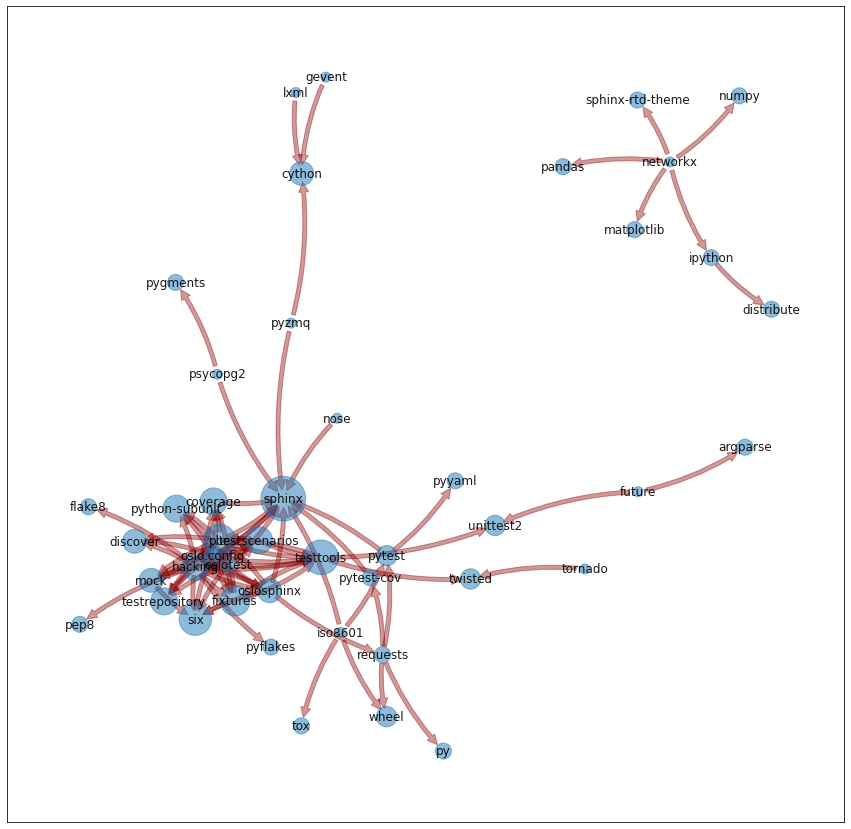

In [7]:
import numpy as np
from matplotlib import pyplot as plt
sampled = [n for n in g.nodes if g.in_degree(n) >= 100]
sg = g.subgraph(sampled).copy()
sg.remove_nodes_from(list(nx.isolates(sg)))
print(nx.info(sg))

node_sizes = np.array([sg.in_degree(n) for n in sg.nodes])
node_sizes = np.interp(node_sizes, (node_sizes.min(), node_sizes.max()), (100, 2000))
pos = nx.spring_layout(sg.to_undirected(), k=10, iterations=2000, seed=1234)
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx_edges(sg, pos, alpha=0.4, edge_color="darkred", arrows=True, arrowsize=20, arrowstyle='simple', connectionstyle='arc3,rad=0.1')
nx.draw_networkx_nodes(sg, pos, alpha=0.5, node_size=node_sizes)
_=nx.draw_networkx_labels(sg, pos, alpha=0.9, font_size=12)


We display in- and out-degree distribution as important graph properties. The log scale is used for the Y axis because of the large range. We also list the first 5 items in both lists and annotate few outliers.

[('requests', 3074),
 ('distribute', 3013),
 ('django', 1987),
 ('six', 1436),
 ('pyyaml', 1045)]
[('isotoma.depends.plone4_1', 148),
 ('onegov.onboarding', 121),
 ('onegov.town', 120),
 ('onegov.election_day', 110),
 ('labkit', 104)]


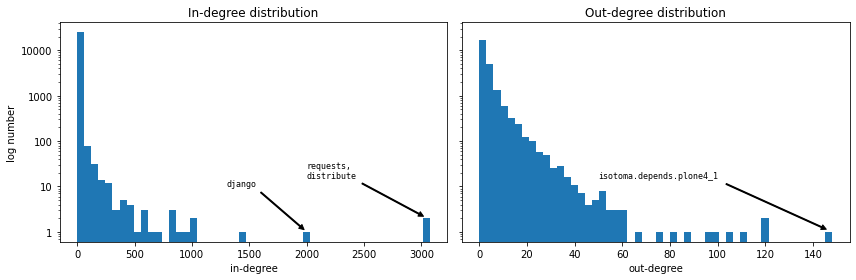

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

indegrees = sorted(g.in_degree(), reverse=True, key=lambda x: x[1])
outdegrees = sorted(g.out_degree(), reverse=True, key=lambda x: x[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey='row')
ax1.hist([x[1] for x in indegrees], bins=50)
ax1.set_yscale('log')
ax1.get_yaxis().set_major_formatter(ScalarFormatter())
ax1.set_ylabel('log number')
ax1.set_xlabel('in-degree')
ax1.set_title('In-degree distribution')
ax1.annotate('requests,\ndistribute', family='monospace',fontsize='smaller', xy=(3050, 2), xytext=(2000, 15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=5))
ax1.annotate('django', family='monospace',fontsize='smaller', xy=(2000, 1), xytext=(1300, 10),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=5))
ax2.hist([x[1] for x in outdegrees], bins=50)
ax2.set_yscale('log')
ax2.get_yaxis().set_major_formatter(ScalarFormatter())
ax2.set_xlabel('out-degree')
ax2.set_title('Out-degree distribution')
ax2.annotate('isotoma.depends.plone4_1', family='monospace',fontsize='smaller', xy=(148, 1), xytext=(50, 15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=5))
fig.tight_layout()
pprint(indegrees[:5])
pprint(outdegrees[:5])

The obtained in- and out-degree distributions are quite different but they share an important similarity: a distribution tail which is not negligible and contains some important outliers. On the in-degree distribution diagram, those are packages which are required by many other packages such as `requests` (a popular library which simplifies HTTP requests). On the out-degree diagram, the highest number of requirements are posed by packages which act as cover packages, e.g., `isotoma.depends.plone4_1` which depends on all packages needed by `Plone 4.1` (a popular CMS).

The `node2vec` library implements Gensim's `Word2Vec` interface for node2vec. This simplifies our tasks and aligns the node2vec algorithm to the word2vec algorithm. We run the node2vec with the increased default parameters. This is not problematic as our network is of a moderate size. We use 500 random walks of length 300 per node.

In [9]:
import node2vec
import random
random.seed(a=12345)
n2v = node2vec.Node2Vec(g, num_walks=300, walk_length=500, workers=4, quiet=True)

For training the model, we use `window=10` (maximum distance between the current and predicted node within a walk) and `min_count=3` to ignore all nodes with lower frequency than 3. The `fit` function accepts [all parameters]((https://radimrehurek.com/gensim/models/word2vec.html)) supported by the Gensim's `Word2vec` and returns a `Word2vec` class instance.

In [10]:
model = n2v.fit(window=10, min_count=3, seed=42)

The computed model can be used for querying just like the word2vec instance. While we cannot expect to get the same level of interpretability as for words because the network contains only the information about package interdependency, the results are at least  interpretable.

In [11]:
print(model.wv.doesnt_match(['scipy', 'numpy', 'matplotlib', 'seaborn', 'unidecode']))
pprint(model.wv.most_similar('keras', topn=5))
pprint(model.wv.most_similar_to_given('nltk', ['plone', 'gensim', 'matplotlib', 'scikit-learn', 'spacy']))

unidecode
[('wabbit-wappa', 0.8208925724029541),
 ('annoy', 0.8048804998397827),
 ('scikit-cuda', 0.756826639175415),
 ('demandimport', 0.7450262308120728),
 ('helpyfuncs', 0.7360456585884094)]
'spacy'


The results reveal some interesting obsrvations. First, `unidecode` is indeed different to the rest in the list because the rest are scientific libraries while `unidecode` is a library for ASCII transliteration of unicode text. Second, `keras` is found to be the most similar to `wabbit-wappa` (`keras` is a high level deep learning library while `'wabbit-wappa'` is a wrapper for fast online interactive machine learning system library called _Vowpal Wabbit_). Finally, `nltk`  is very similar to `spacy` because they are both natural language processing libraries for Python. Note that the similarity was measured based on package dependency which is only weakly related to the actual functionality of packages. Evidently, even this is enough to get interpretable outcomes. 

To obain the $NxK$ matrix which holds node embeddings as rows, we extract node vectors and construct an array.

In [12]:
import numpy as np
node_embeddings = np.array([model.wv.get_vector(node) for node in model.wv.vocab])
print(node_embeddings.shape)

(25119, 128)


Node embeddings can be used in visualization. We visualize node embeddings in the 2D space using t-SNE to see if we get any well-separated clusters.

In [13]:
from sklearn.manifold import TSNE
node_embeddings_2D = TSNE(n_components=2).fit_transform(node_embeddings)

To draw the complete dataset, we keep the size of points small. The obtained scatterplot suggests that there are several smaller clusters of similar nodes and a large number of non-specific nodes which are dispersed. Note that t-SNE is stohastic so the 2D projection looks different on every run.

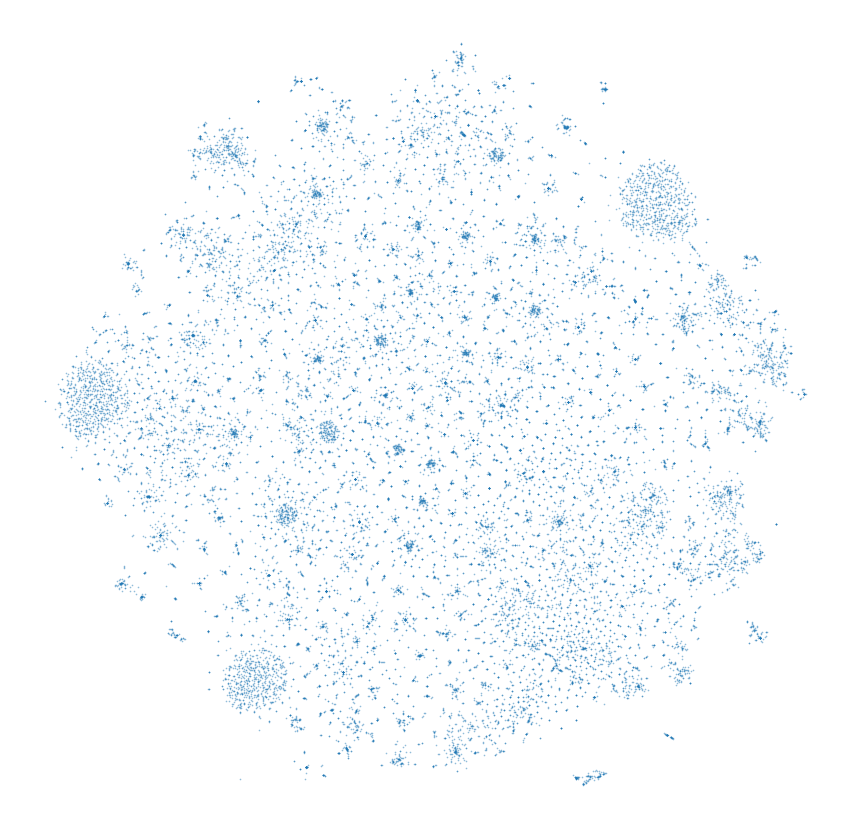

In [14]:
x = node_embeddings_2D[:,0]
y = node_embeddings_2D[:,1]
figure = plt.figure(figsize=(15, 15))
_ = plt.scatter(x, y, s=0.5, alpha=0.4)
_ = plt.axis('off')

Finally, we mark some popular python packages on the scatterplot to see if can draw any conclusions. We use manually compiled lists of popular packages for each of the categories listed below where each category will use a different color:
- GUI development
- database interfaces
- web development
- scientific programming
- game development

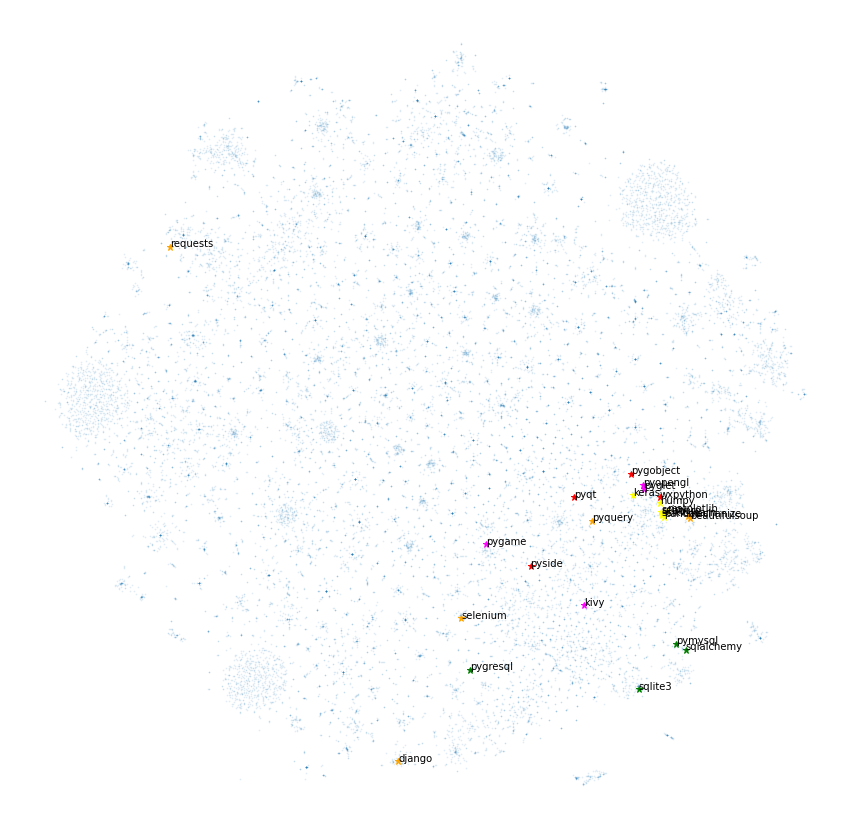

In [17]:
gui = ['wxpython', 'pygobject', 'pyqt', 'pyside']
db = ['pymysql', 'pygresql', 'sqlalchemy', 'sqlite3']
web = ['beautifulsoup', 'mechanize', 'requests', 'selenium', 'pyquery', 'django']
sci = ['numpy', 'scipy', 'matplotlib', 'pandas', 'scikit-learn', 'seaborn', 'keras']
game = ['pygame', 'pyglet', 'pyopengl', 'kivy']

new_figure = plt.figure(figsize=(15, 15))
_ = plt.scatter(x, y, s=0.5, alpha=0.1)
_ = plt.axis('off')

node_labels = {node:i for i,node in enumerate(model.wv.vocab)}
for group, color in [(gui, 'red'), (db, 'green'), (web, 'orange'), (sci, 'yellow'), (game, 'magenta')]:
    for package in group:
        plt.plot(x[node_labels[package]], y[node_labels[package]], '*', color=color, mew=1, ms=7)
        plt.annotate(package, (x[node_labels[package]], y[node_labels[package]]), fontsize=10)

The results are indeed interpretable. Scientific packages form the tightest cluster as their dependency connections are most similar. Parts of database interface, game development and GUI development packages are also close, while web development libraries are the most diverse. This is not surprising as the list contains packages for rather different purposes, e.g., `django` (web framework), `mechanize` (programmatic web browsing), and `requests` (simplifies HTTP requests).